In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [40]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.policies import policy_saver
from tf_agents.trajectories import TimeStep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-04 14:11:39.066874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:11:39.089512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:11:39.089749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"pred_session_name" : 'rand_walk_interpol_new_dataset_1_uav',
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function)



There are 2500 training grids.
There are 1430 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))


2023-06-04 14:12:22.079130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:22.079441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:22.079671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12

2023-06-04 14:12:28.120026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:28.120281: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 14:12:28.120511: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 14:12:28.131610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:28.131859: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-04 14:12:29.173217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:29.173443: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 14:12:29.173716: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 14:12:29.174307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:29.174535: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-04 14:12:33.240933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:33.241137: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 14:12:33.241235: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 14:12:33.241558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:33.241751: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-04 14:12:34.161206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:34.161418: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-04 14:12:34.161535: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-04 14:12:34.161863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 14:12:34.162091: I tensorflow/compiler/xla/stream_executor/

In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-04--14:12:35'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_step = train_py_env.reset()
        reward_in_episode = 0
        while not time_step.is_last():
            time_step = train_py_env.step(action=1)
            reward_in_episode += time_step.reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

2023-06-04 14:12:36.938999: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-04 14:12:36.939953: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-04 14:12:45.780407: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 30.53343963623047
Average error 9.466560560120055


Timer unit: 0.001 s

Total time: 125.137 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 468

Line #      Hits         Time  Per Hit   % Time  Line Contents
   468                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   469        52          2.6      0.0      0.0  		city_ob = self.building_grid
   470        52          2.1      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   471        52          2.2      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   472                                           
   473                                           		# Get measured coords
   474        52         15.1      0.3      0.0  		measured_coords = self.get_measured_coords()
   475                                           
   476                                           		# UAV location grid
   477        52          2.7      0.1      0.0  		uav_location_grid

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-04 14:14:43.604548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-04 14:14:45.887397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [57]:
# Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes=10, convert_ts_to_tf = False):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        if convert_ts_to_tf:
          # Create a timestep with TF values
          step_type = tf.convert_to_tensor(time_steps[agent_idx].step_type, name='step_type')
          reward = tf.convert_to_tensor(time_steps[agent_idx].reward)
          discount = tf.convert_to_tensor(time_steps[agent_idx].discount)
          observation = tf.convert_to_tensor(time_steps[agent_idx].observation)
          tf_ts = TimeStep(step_type=step_type, reward=reward, discount=discount, observation=observation)
        else:
          # We can use numpy inputs
          tf_ts = time_steps[0]
        # Get action
        action_step = policy.action(tf_ts)
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors), episode_errors

In [53]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(eval_env, eval_py_env, random_policy, num_episodes=1)

print((rand_reward, rand_pred_error))


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'is_last'

In [ ]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,     
  sequence_length=n_step_update+1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpcf3evkot.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpcf3evkot
[reverb/cc/platform/default/server.cc:71] Started replay server on port 35477


In [ ]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([[[0.17172612, 0.17719433, 0.        ],
         [0.12862241, 0.16710156, 0.        ],
         [0.25217724, 0.15426287, 0.        ],
         ...,
         [0.71820074, 0.0593503 , 0.        ],
         [0.7243862 , 0.06363556, 0.        ],
         [0.7263637 , 0.07668928, 0.        ]],
 
        [[0.        , 0.1745719 , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.7221126 , 0.0572904 , 0.        ],
         [0.7356545 , 0.05680133, 0.        ],
         [0.73342395, 0.06014795, 0.        ]],
 
        [[0.        , 0.18986015, 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.73109597, 0.05445139, 0.        ],
         [0.73192567, 0.06145607, 0.        ],
         [0.7309059 , 0.06371347, 0.        ]],
 
        ...,
 
        [[0.        ,

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [ ]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [ ]:
env._reset()
print("")

In [ ]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
best_reward = np.inf
losses = []
collect_rewards = []

In [ ]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [ ]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)


for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step.reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
      avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
      print('step = {0}: Average Return 2 = {1}, Average Error 2 = {2}'.format(step, avg_return, avg_error))
      print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1992183) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1992183) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1992183) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1992183) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1992183) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1992183) so Table uniform_table is accessed directly without gRPC.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
2023-06-04 14:32:36.585528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum' with dtype int32
	 [[{{node critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum}}]]
2023-06-04 14:32:36.592669: I tensorflow/core/common_runtime/executor.cc:1197] [/d

step = 0: loss = 4.248671531677246,  rew = 0.0
step = 0: Average Return = 23.179601669311523, Average Error = 17.115927854108484
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 0: Average Return 2 = 24.70722770690918, Average Error 2 = 15.457806812948787
step = 0: Average Return 3 = 23.46501350402832, Average Error 3 = 16.95436207620712
step = 1000: loss = 4.198587894439697,  rew = 23.485593497753143
step = 2000: loss = 4.1439361572265625,  rew = 24.4754821062088
step = 3000: loss = 4.095338821411133,  rew = 24.351510405540466
step = 4000: loss = 4.046041011810303,  rew = 23.327696323394775
step = 5000: loss = 3.9929909706115723,  rew = 22.585080564022064
step = 6000: loss = 3.948108673095703,  rew = 23.494845628738403
step = 7000: loss = 3.9180545806884766,  rew = 22.861015796661377
step = 8000: loss = 3.9043455123901367,  rew = 21.348154544830322
step = 9000: loss = 3.853684902191162,  rew = 24.84685778617859
step = 10000: loss = 3.8205652236938477,  rew = 22.98389822244644
step = 11000: loss = 3.8398945331573486,  rew = 23.011399805545807
step = 12000: loss = 3.829496383666992,  rew = 24.428139626979828
step = 13000: loss = 3.786701202392578,  rew =

step = 50000: Average Return = 23.32195281982422, Average Error = 17.100323809995764
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 50000: Average Return 2 = 24.337785720825195, Average Error 2 = 15.91577852064441
step = 50000: Average Return 3 = 23.531339645385742, Average Error 3 = 16.72322912434813
step = 51000: loss = 3.697812795639038,  rew = 22.611340880393982
step = 52000: loss = 3.729328155517578,  rew = 24.517539143562317
step = 53000: loss = 3.7295079231262207,  rew = 24.25656169652939
step = 54000: loss = 3.680704116821289,  rew = 24.310728907585144
step = 55000: loss = 3.7049641609191895,  rew = 21.520350873470306
step = 56000: loss = 3.6532466411590576,  rew = 25.979405641555786
step = 57000: loss = 3.7110793590545654,  rew = 23.841974139213562
step = 58000: loss = 3.64292311668396,  rew = 27.32132077217102
step = 59000: loss = 3.7244977951049805,  rew = 20.766620337963104
step = 60000: loss = 3.746109962463379,  rew = 23.971641063690186
step = 61000: loss = 3.7315123081207275,  rew = 23.11243712902069
step = 62000: loss = 3.67233943939209,  rew = 26.11427903175354
step = 63000: loss = 3.7239575

step = 100000: Average Return = 23.389488220214844, Average Error = 16.94509515074224
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 100000: Average Return 2 = 23.56329345703125, Average Error 2 = 16.78294208500042
step = 100000: Average Return 3 = 24.07469367980957, Average Error 3 = 16.07206652248208
step = 101000: loss = 3.6304376125335693,  rew = 23.578643798828125
step = 102000: loss = 3.692995071411133,  rew = 26.198428869247437
step = 103000: loss = 3.6393771171569824,  rew = 24.817781150341034
step = 104000: loss = 3.5844340324401855,  rew = 24.440209567546844
step = 105000: loss = 3.558403968811035,  rew = 23.326033353805542
step = 106000: loss = 3.5780153274536133,  rew = 23.564989864826202
step = 107000: loss = 3.6255483627319336,  rew = 26.218420267105103
step = 108000: loss = 3.5959722995758057,  rew = 22.62028455734253
step = 109000: loss = 3.571556806564331,  rew = 24.29545968770981
step = 110000: loss = 3.652678966522217,  rew = 23.755665123462677
step = 111000: loss = 3.572399139404297,  rew = 25.305292010307312
step = 112000: loss = 3.6072652339935303,  rew = 23.112665116786957
step = 113000

step = 150000: Average Return = 24.132230758666992, Average Error = 16.136380865383053
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 150000: Average Return 2 = 23.878070831298828, Average Error 2 = 16.375748882524007
step = 150000: Average Return 3 = 23.85142707824707, Average Error 3 = 16.461473607311433
step = 151000: loss = 3.464743137359619,  rew = 25.199899077415466
step = 152000: loss = 3.5015978813171387,  rew = 21.101614832878113
step = 153000: loss = 3.5911779403686523,  rew = 24.0299791097641
step = 154000: loss = 3.525435209274292,  rew = 24.902838468551636
step = 155000: loss = 3.5907368659973145,  rew = 23.48759174346924
step = 156000: loss = 3.4407272338867188,  rew = 21.271078288555145
step = 157000: loss = 3.438006639480591,  rew = 23.654858767986298
step = 158000: loss = 3.4922609329223633,  rew = 23.43996912240982
step = 159000: loss = 3.4573473930358887,  rew = 25.99654793739319
step = 160000: loss = 3.5052881240844727,  rew = 24.675436317920685
step = 161000: loss = 3.5096232891082764,  rew = 24.24454391002655
step = 162000: loss = 3.421504497528076,  rew = 25.243008136749268
step = 163000

step = 300000: Average Return = 24.237274169921875, Average Error = 15.85548138356156
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 300000: Average Return 2 = 24.157758712768555, Average Error 2 = 16.033531358070718
step = 300000: Average Return 3 = 24.2029972076416, Average Error 3 = 15.98232488548535
step = 301000: loss = 3.3885786533355713,  rew = 23.132026195526123
step = 302000: loss = 3.434112548828125,  rew = 23.476602137088776
step = 303000: loss = 3.5012426376342773,  rew = 23.545272648334503
step = 304000: loss = 3.5023884773254395,  rew = 25.2709299325943
step = 305000: loss = 3.47257924079895,  rew = 26.294979453086853
step = 306000: loss = 3.534855842590332,  rew = 23.58791083097458
step = 307000: loss = 3.5170624256134033,  rew = 24.6453195810318
step = 308000: loss = 3.5269360542297363,  rew = 24.101513624191284
step = 309000: loss = 3.3903627395629883,  rew = 22.326233983039856
step = 310000: loss = 3.51164174079895,  rew = 23.658618330955505
step = 311000: loss = 3.3951148986816406,  rew = 24.36586320400238
step = 312000: loss = 3.3489110469818115,  rew = 27.202191948890686
step = 313000: lo

step = 350000: Average Return = 24.73577117919922, Average Error = 15.475116601457257
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 350000: Average Return 2 = 23.416481018066406, Average Error 2 = 16.88428312084328
step = 350000: Average Return 3 = 24.160484313964844, Average Error 3 = 16.150096946390885
step = 351000: loss = 3.480494976043701,  rew = 19.592301547527313
step = 352000: loss = 3.4497263431549072,  rew = 25.947219133377075
step = 353000: loss = 3.3818674087524414,  rew = 23.736554384231567
step = 354000: loss = 3.417151927947998,  rew = 25.44870674610138
step = 355000: loss = 3.373718500137329,  rew = 25.63975751399994
step = 356000: loss = 3.395446538925171,  rew = 25.022590160369873
step = 357000: loss = 3.394104480743408,  rew = 21.258099377155304
step = 358000: loss = 3.379283905029297,  rew = 25.307586789131165
step = 359000: loss = 3.4123618602752686,  rew = 24.664443731307983
step = 360000: loss = 3.406978130340576,  rew = 20.28440237045288
step = 361000: loss = 3.390089511871338,  rew = 21.118342876434326
step = 362000: loss = 3.412332534790039,  rew = 26.45741105079651
step = 363000: l

step = 950000: Average Return = 25.052114486694336, Average Error = 15.199339568790347
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 950000: Average Return 2 = 24.212467193603516, Average Error 2 = 15.973369539919672
step = 950000: Average Return 3 = 23.64171600341797, Average Error 3 = 16.54248498876034
step = 951000: loss = 3.4186203479766846,  rew = 20.445063710212708
step = 952000: loss = 3.461134910583496,  rew = 25.65496265888214
step = 953000: loss = 3.4769933223724365,  rew = 23.958897590637207
step = 954000: loss = 3.404635190963745,  rew = 25.487372279167175
step = 955000: loss = 3.4510204792022705,  rew = 22.498832643032074
step = 956000: loss = 3.499635696411133,  rew = 25.320816040039062
step = 957000: loss = 3.473348379135132,  rew = 25.694456696510315
step = 958000: loss = 3.455277442932129,  rew = 22.93713688850403
step = 959000: loss = 3.489137649536133,  rew = 24.14080798625946
step = 960000: loss = 3.423269271850586,  rew = 24.661649763584137
step = 961000: loss = 3.572049140930176,  rew = 20.271818339824677
step = 962000: loss = 3.409158229827881,  rew = 24.252639710903168
step = 963000: l

step = 1000000: Average Return = 24.861183166503906, Average Error = 15.192255266573035
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 1000000: Average Return 2 = 24.262598037719727, Average Error 2 = 15.95634023544845
step = 1000000: Average Return 3 = 24.809316635131836, Average Error 3 = 15.422714704710039
step = 1001000: loss = 3.475693702697754,  rew = 22.581596672534943
step = 1002000: loss = 3.490251064300537,  rew = 24.26343262195587
step = 1003000: loss = 3.3557043075561523,  rew = 23.774105310440063
step = 1004000: loss = 3.53602933883667,  rew = 25.066116452217102
step = 1005000: loss = 3.2947916984558105,  rew = 25.397074222564697
step = 1006000: loss = 3.464261531829834,  rew = 26.119264960289
step = 1007000: loss = 3.485572338104248,  rew = 23.850567638874054
step = 1008000: loss = 3.4022340774536133,  rew = 20.1600581407547
step = 1009000: loss = 3.503635883331299,  rew = 25.279539823532104
step = 1010000: loss = 3.378807306289673,  rew = 22.370366752147675
step = 1011000: loss = 3.4212543964385986,  rew = 22.68325984477997
step = 1012000: loss = 3.471564292907715,  rew = 22.780877351760864
step 

step = 1500000: Average Return = 24.866830825805664, Average Error = 15.173837880586385
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-04--14:12:35/assets


step = 1500000: Average Return 2 = 24.332435607910156, Average Error 2 = 16.09653228820546
step = 1500000: Average Return 3 = 24.53632164001465, Average Error 3 = 15.486570837478688
step = 1501000: loss = 3.493267297744751,  rew = 23.316320776939392
step = 1502000: loss = 3.4942314624786377,  rew = 24.453933537006378
step = 1503000: loss = 3.5181641578674316,  rew = 21.623317897319794
step = 1504000: loss = 3.464857578277588,  rew = 24.6245875954628
step = 1505000: loss = 3.3982605934143066,  rew = 21.983975172042847
step = 1506000: loss = 3.4892659187316895,  rew = 22.742080688476562
step = 1507000: loss = 3.4856348037719727,  rew = 23.04254174232483
step = 1508000: loss = 3.4607856273651123,  rew = 23.959609866142273
step = 1509000: loss = 3.47225284576416,  rew = 26.46144926548004
step = 1510000: loss = 3.4582836627960205,  rew = 24.285076558589935
step = 1511000: loss = 3.4528355598449707,  rew = 24.783965945243835
step = 1512000: loss = 3.5166707038879395,  rew = 24.43874031305313

KeyboardInterrupt: 

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

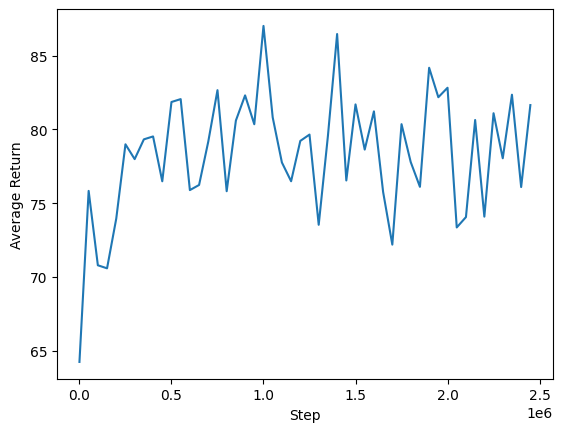

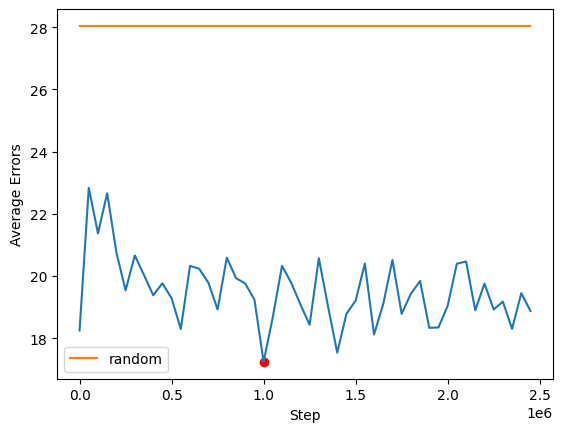

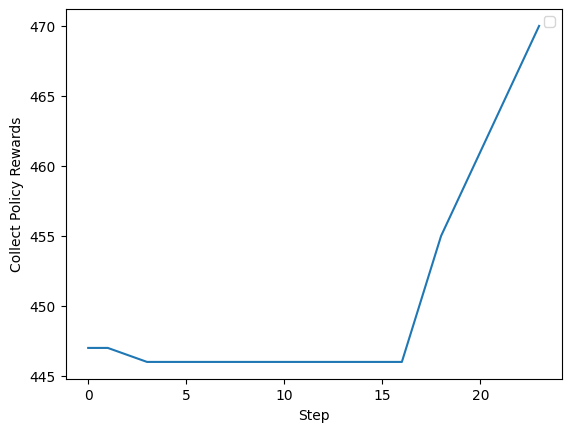

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
env.random_init = 0
env.n_uavs = 1

In [ ]:
# Evaluate model again
avg_return, avg_error, errors = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True), 500)
print(avg_return, avg_error, np.median(errors))

21.452129745483397 21.481614650464923 14.325682332332395


In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

22.378853 17.984891216551663


In [67]:
saved_policy = tf.saved_model.load(train_log_dir)
saved_policy.time_step_spec = agent.policy.time_step_spec
saved_policy.action_spec = agent.policy.action_spec
saved_policy.policy_state_spec = agent.policy.policy_state_spec
saved_policy.info_spec = agent.policy.info_spec
avg_return, avg_error, errors = compute_avg_return(env, py_tf_eager_policy.PyTFEagerPolicy(saved_policy, use_tf_function=True), 500, convert_ts_to_tf=False)
print(avg_return, avg_error, np.median(errors))

23.198183155059816 16.80181656776208 13.78789946007063
